##### Author: Will Stonehouse
TO DO: Turn the dataset into an edf file. Turn edf file into a raw file.<br>
Implement the phase properly: https://github.com/aaravindravi/Brain-computer-interfaces/blob/master/notebooks/introduction_ssvep.ipynb<br>
Use Exo dataset: http://moabb.neurotechx.com/docs/generated/moabb.datasets.SSVEPExo.html#moabb.datasets.SSVEPExo<br>
Cool interface: https://openbci.com/community/spir-o-spell-an-optimized-mi-based-bci-speller/

## Making a SSVEP-based Brain-Comutper Interface  

### Purpose:
This notebook is my attempt at self learning how to perform EEG analysis of SSVEP data. We are using the BETA dataset (2016) from the BCI Lab at the University of Tsinghua as it is the most comprehensive to date. Secondly, we will use pipelines from the MOABB (Mother of all BCI Benchmarks) library for classification methods. Lastly, we will train a neural network. In this notebook you will learn how to load data, epoch it, graph it different ways, test classification algorithms, train neural networks, and more! This notebook should eventually serve as an unintimidating, but robust tutorial on SSVEP-based BCIs for CruX UCLA (A NeuroTechX chapter). Some programming experience and python basics is a must. Aside from the BCI dependencies listed below, we will learn how to use amazing python libraries like matplot.lib, scipy, scikitlearn, pandas, tensorflow, and numpy (Pronounced num-pie, NOT num-pee. Looking at you Manya).

### BCI Libraries:
MNE, MOABB 

### Table of Contents:
1. Introduction
2. Dataset Inspection
3. Cross Subject Analysis
4. Building and Training Convolutional Neural Network

## 1. Introduction

Let's start with the very basics. Any BCI analysis is defined by three elements: A <b>dataset</b>,
a <b>context</b>, and a <b>pipeline</b> (Jayaram et al., 2018). Once you have analyzed these three elements, you should be on the right track to creating a functional BCI.

1. A <b>dataset</b> is the quantitative data we get from an experiment. Datasets try to capture one type of EEG signal across many participants and trials. For example: motor imagery, ERP, alpha-power, and SSVEP. In our case, we will evaluate a SSVEP dataset.
2. Knowing the <b>context</b> is how we know what parameters we need to use in our pipeline. This is where the bulk of data analysis will occur. This will include data inspection for signal-noise,  periodogram graphing, artifact detection, and dimensionality reduction.
3. A <b>pipeline</b> is the algorithm that process data into labels. Remeber, our ultimate goal is to categorize SSVEP signals by labeling them. In this notebook, we will use MOABB pipelines which is based on the skikit-learn API.

SSVEP is a type of neural signal with a high signal-noise ratio. SSVEP is the most popular type of neural signal because of its functionality. Unlike moter imagery and alpha wave decoders, you can make non-binary interfaces. This means that you can have more than two keys for a given interface. With this sort of capability, SSVEP signals can allow us to create keyboards with multiple keys.

## 2. Dataset Inspection

The dataset consists of 64-channel Electroencephalogram (EEG) data from 35 healthy subjects (8 experienced and 27 naïve) while they performed a cue-guided target selecting task. The virtual keyboard of the speller was composed of 40 visual flickers, which were coded using a joint frequency and phase modulation (JFPM) approach. The stimulation frequencies ranged from 8 Hz to 15.8 Hz with an interval of 0.2 Hz. The phase difference between two adjacent frequencies was 0.5π. For each subject, the data included six blocks of 40 trials corresponding to all 40 flickers indicated by a visual cue in a random order. The stimulation duration in each trial was five seconds. In total, there are 210 epochs for every frequency.

In [12]:
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
' LOAD DATA '
mat = loadmat('BetaDataset/S1.mat')
data = mat['data']
print(data.shape)

' LOAD LABELS '
freq_phase = loadmat('BetaDataset/Freq_Phase.mat')
phases = freq_phase['phases']
freq = freq_phase['freqs']
print(freq.shape)

(64, 1500, 40, 6)
(1, 40)


>1 Subject: 64 channels, 1500 time points, 40 different flicker frequency, 6 trials<br>
>1 Trial: 40 labels

#### Time Series

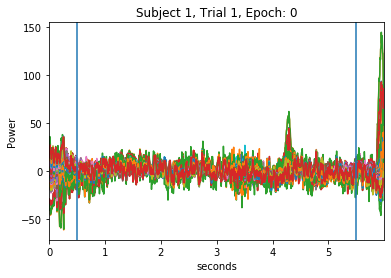

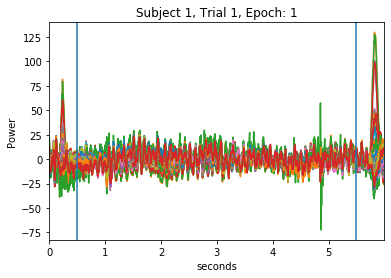

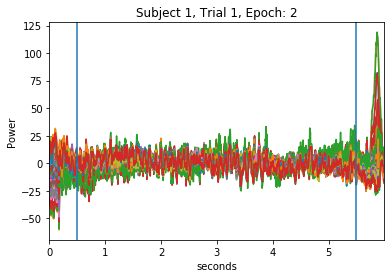

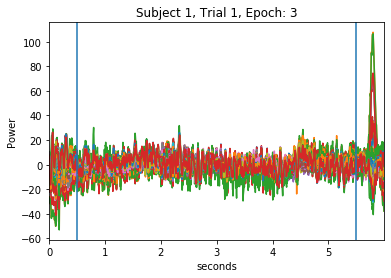

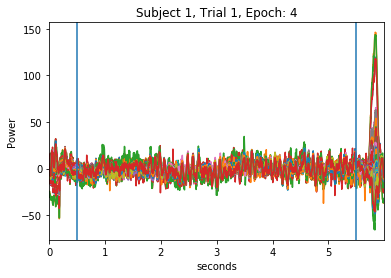

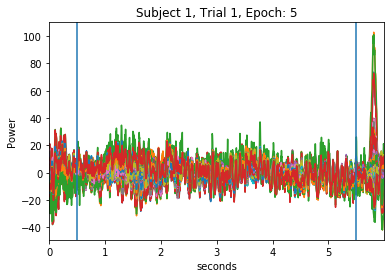

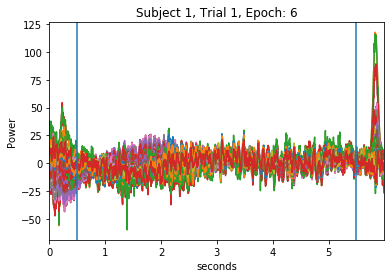

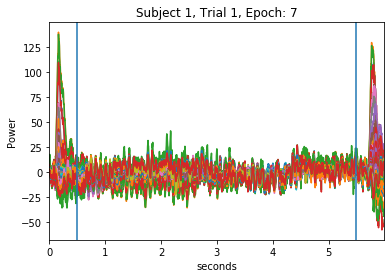

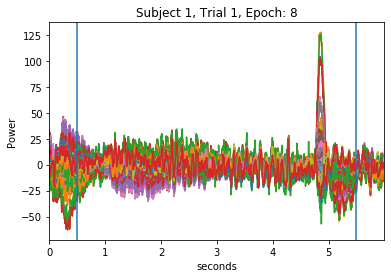

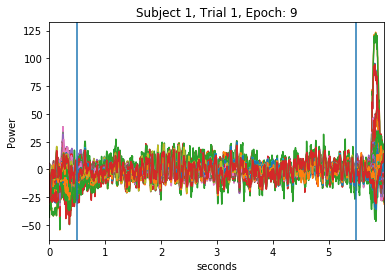

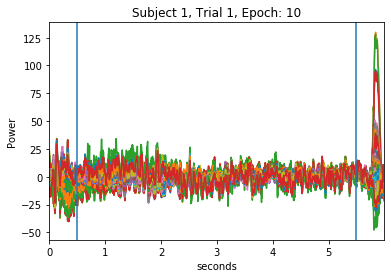

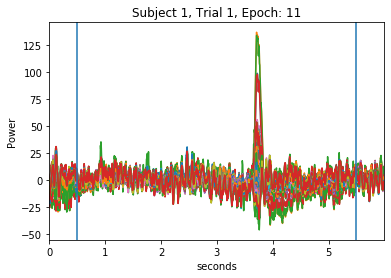

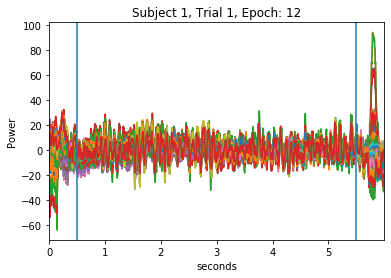

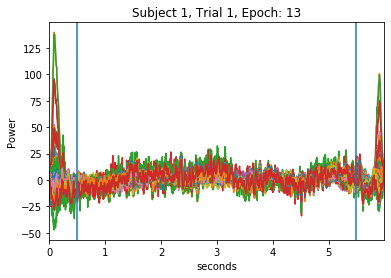

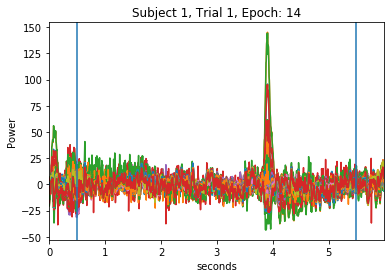

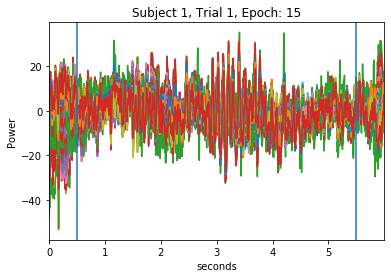

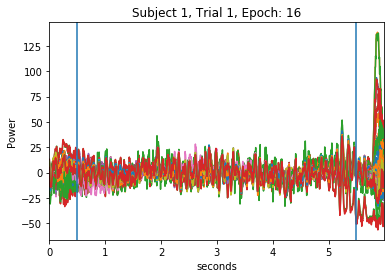

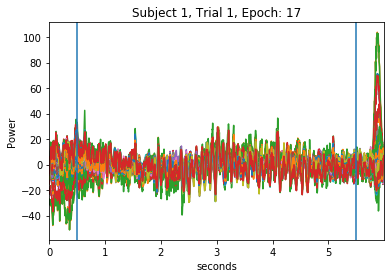

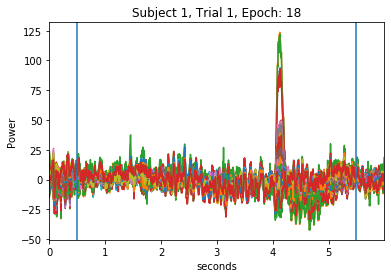

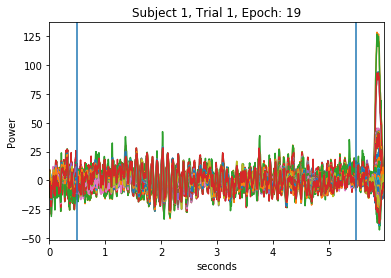

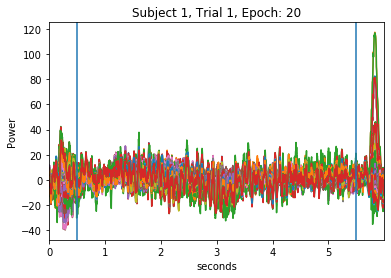

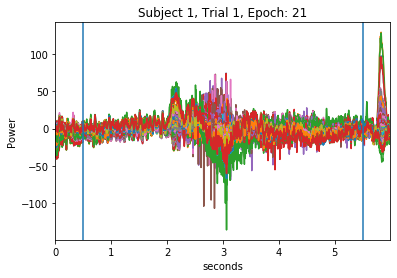

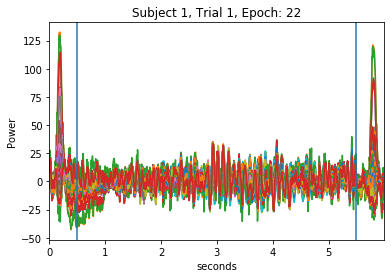

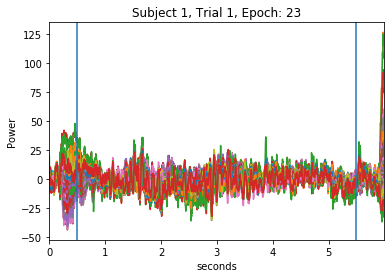

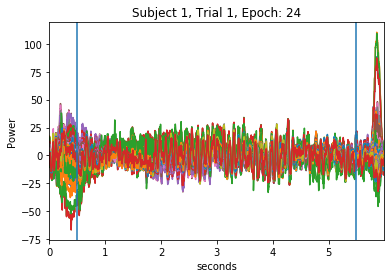

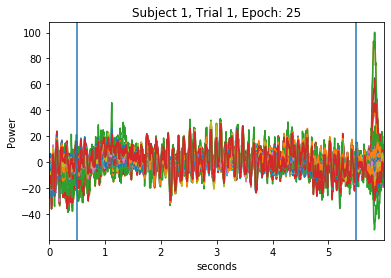

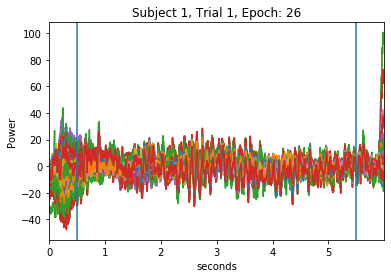

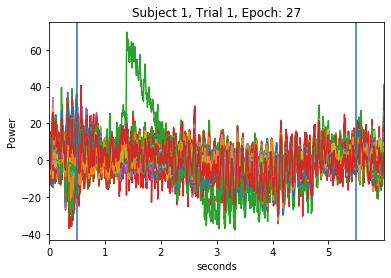

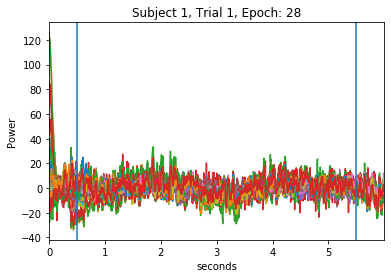

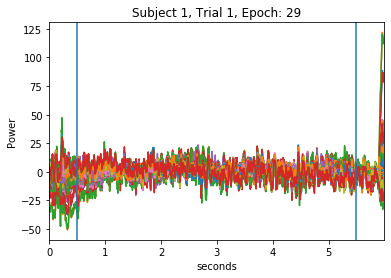

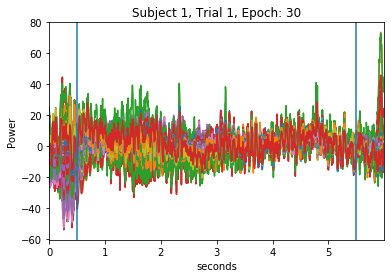

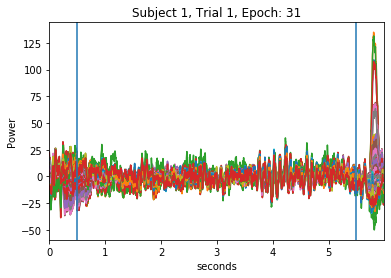

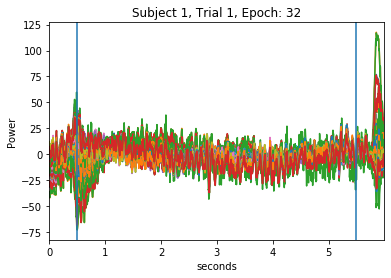

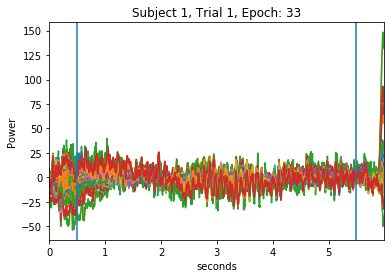

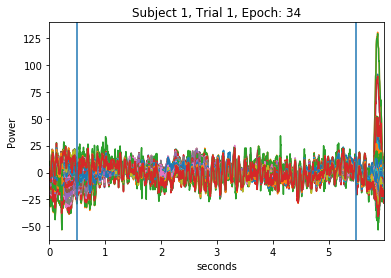

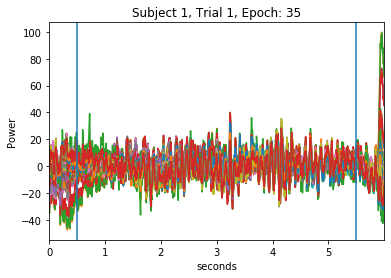

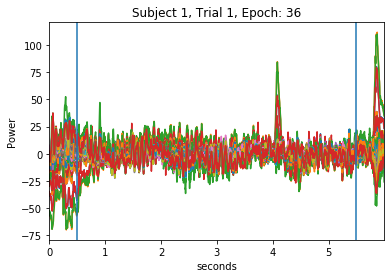

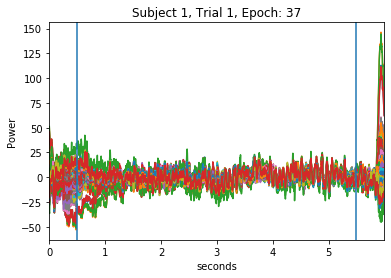

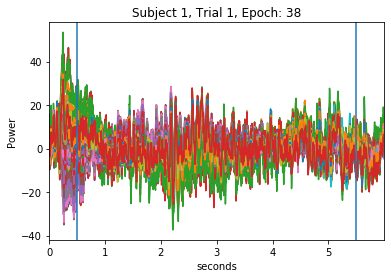

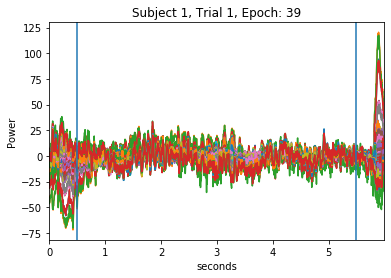

In [4]:
'Graph Time Series'
trial=0
for j in range(40):
    for i in range(64):
        sample = data[i,:,j,0].T # Take the first trial
        seconds = np.arange(sample.size)/sf
        plt.plot(seconds, sample)
    plt.title("Subject 1, Trial 1, Epoch: "+str(j))
    plt.xlabel('seconds')
    plt.ylabel('Power')
    plt.xlim([seconds.min(), seconds.max()])
    plt.axvline(x=0.5)
    plt.axvline(x=5.5)
    plt.show()

<br>Each trial started with a .5 sec visual cue (a red square) and ended with a .5 sec blank screen. We need to index the time series with [125:1375]. The two blue lines denote this. Notice how the signal from the visual cue and the blank screen is much stronger than the flickering stimulus. We may have to implement <b>artifact removal</b>. Quick inspection shows a major artifact in the 15th epoch.

#### Power Spectral Density

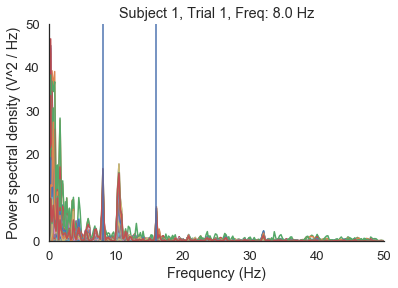

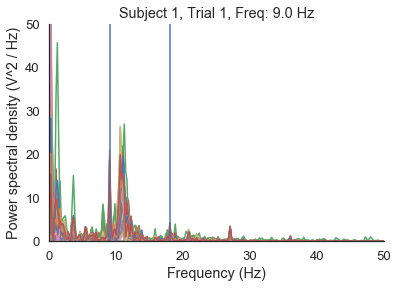

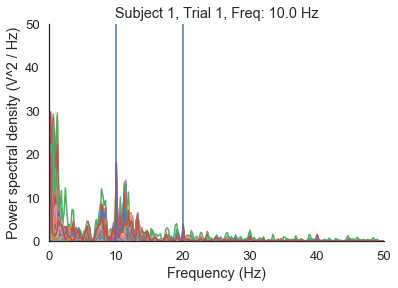

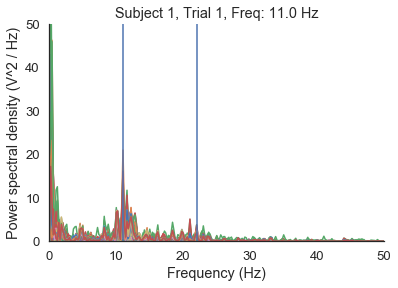

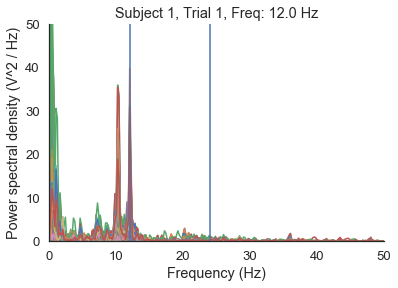

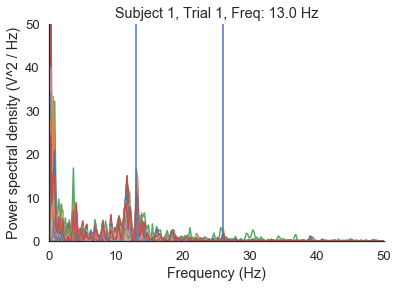

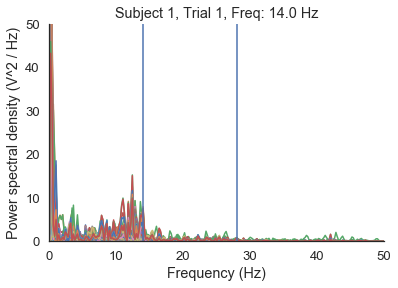

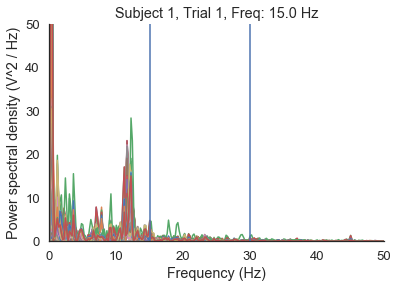

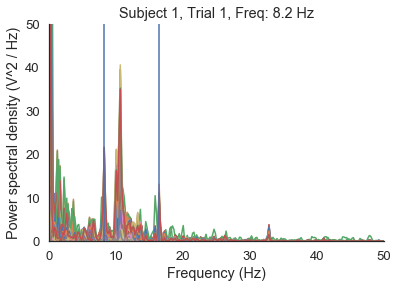

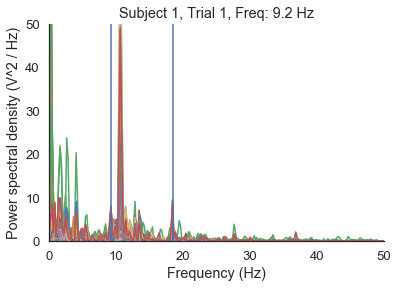

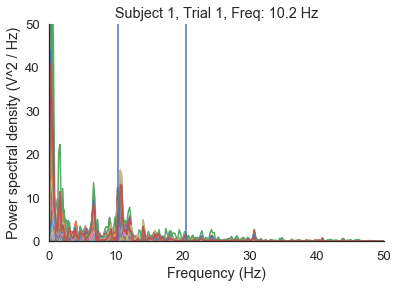

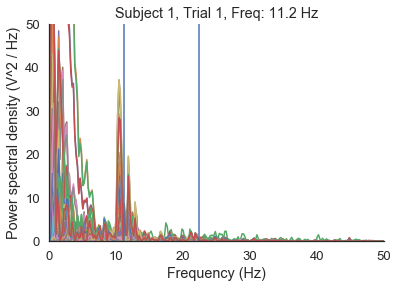

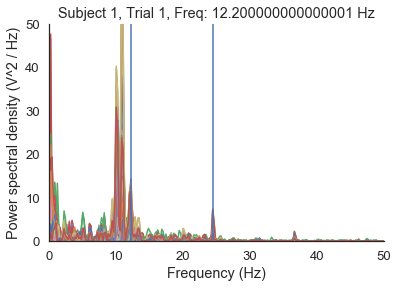

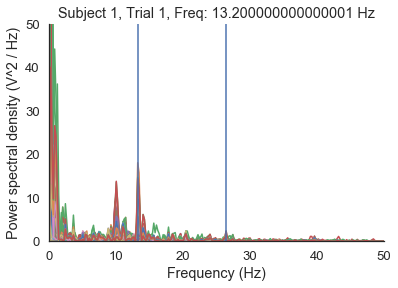

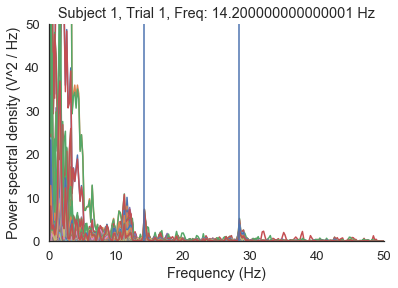

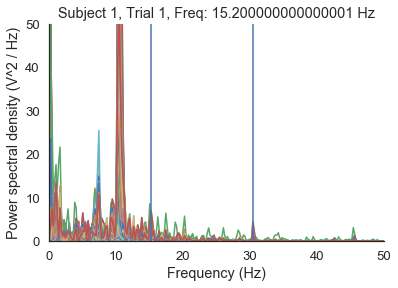

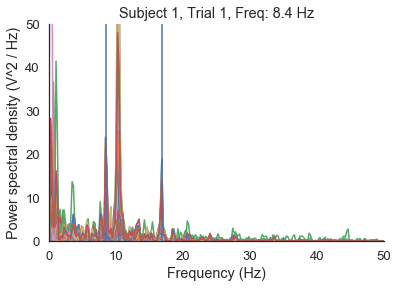

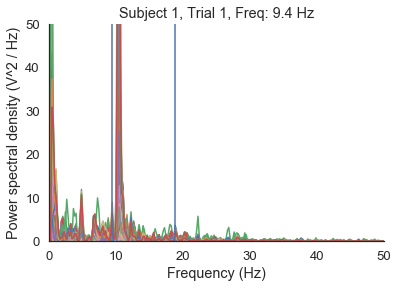

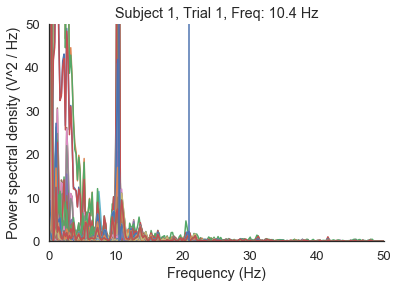

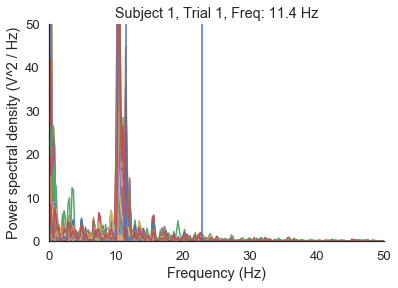

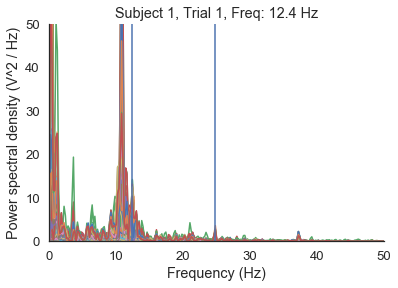

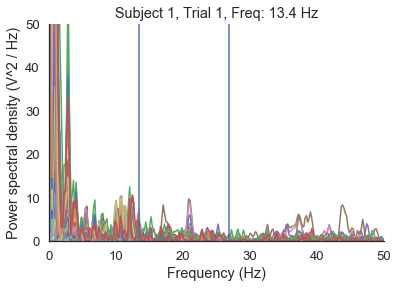

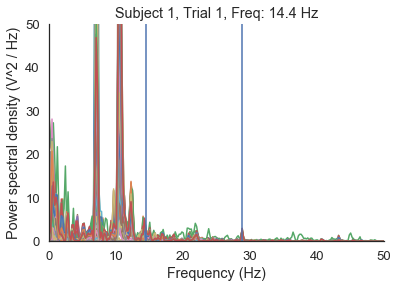

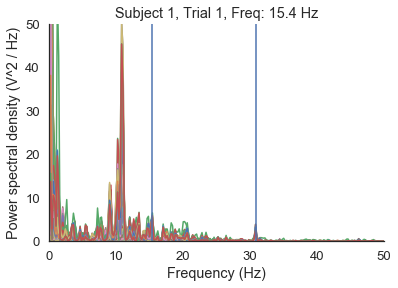

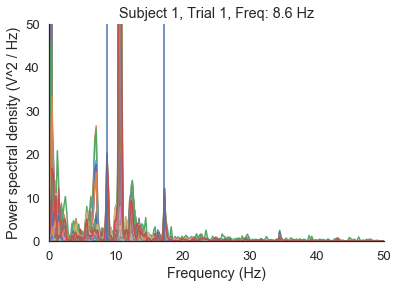

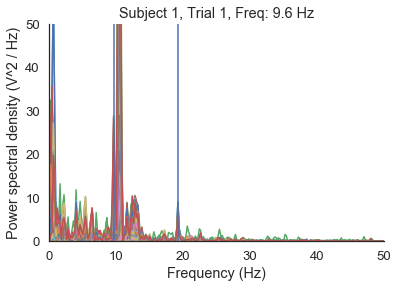

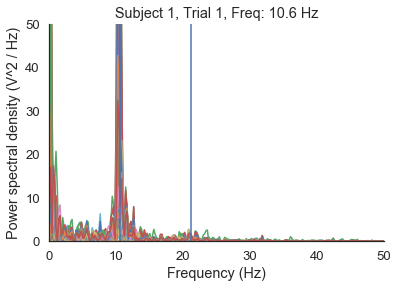

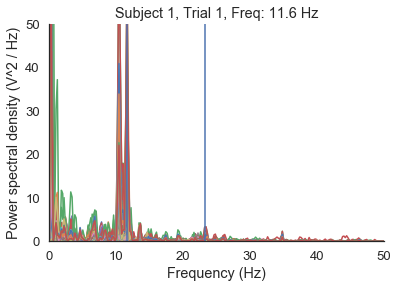

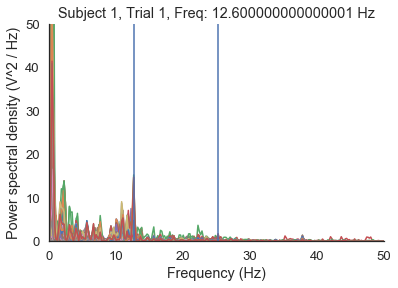

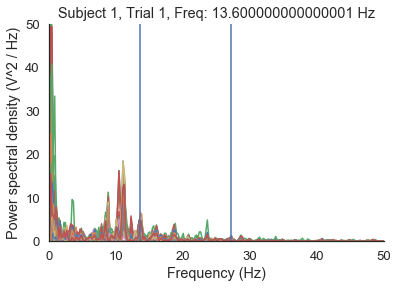

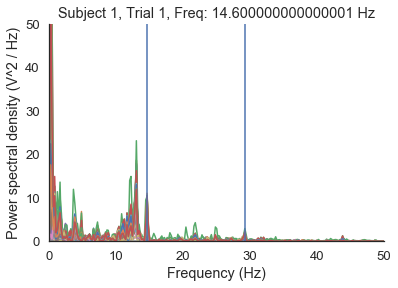

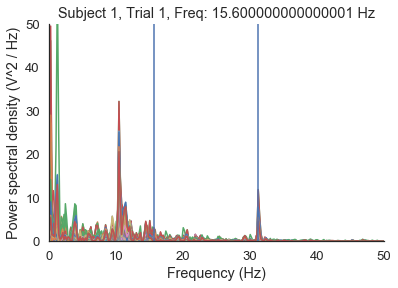

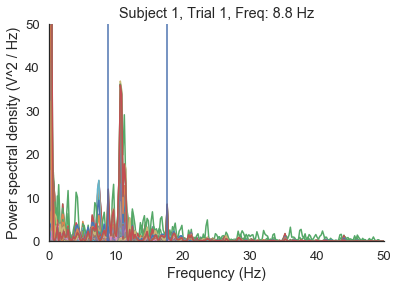

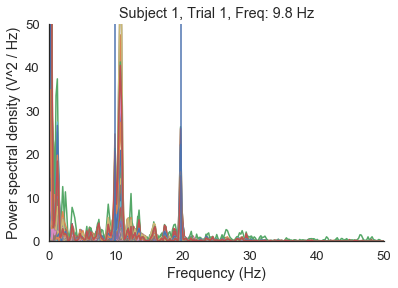

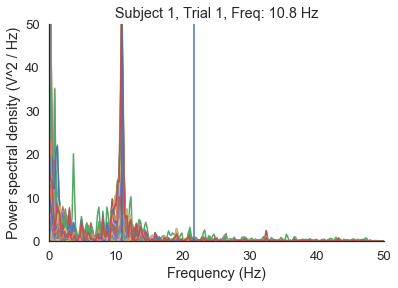

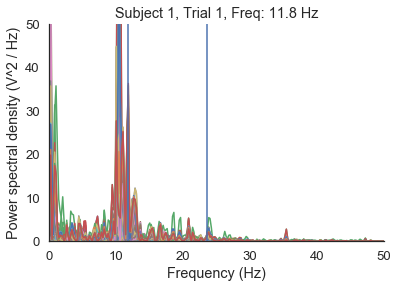

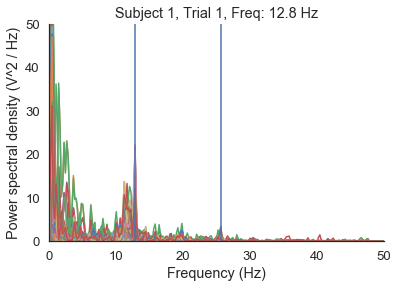

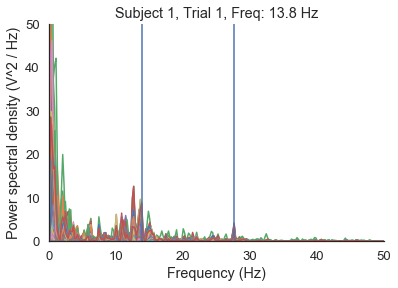

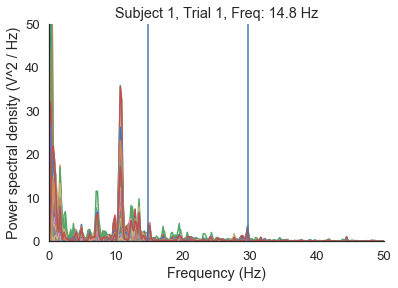

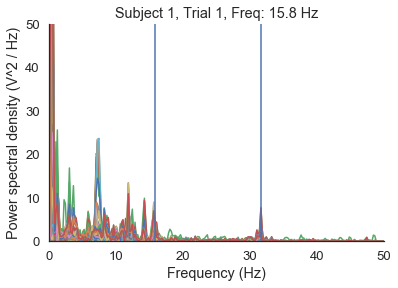

In [16]:
'Vars'
sf = 250
win = sf*5
trial=0
epochs=40
freq_max = 50 # We are looking for something between 8-16 HZ

'Graph PSD'
for j in range (epochs):
    for i in range(64):
        sample = data[i,125:1375,j,trial].T # Cut off the first and last 125 samples
        freqs, psd = signal.welch(sample, fs=sf, nperseg=win)
        sns.set(font_scale=1.2, style='white')
        plt.plot(freqs,psd)   
    sns.despine()
    plt.title("Subject 1, Trial 1, Freq: "+str(freq[0,j])+str(" Hz"))
    plt.ylabel('Power spectral density (V^2 / Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylim([0, freq_max])
    plt.xlim([0, freq_max])
    plt.axvline(x=freq[0,j])
    plt.axvline(x=freq[0,j]*2)
    plt.show()

# First verticle line is the target frequency. The second line is the higher harmonic

<br>In most cases the second largest spike is in line with the predicted frequency. I included a second line for each frequency's <b>higher harmonic</b>. Notice that the largest spikes in all the epochs are in the alpha range (8-12 Hz). Aside from the low frequncy noise, alpha bands are the most abundant band in EEG data. The data looks great so far!

We can reduce the amount of channels that are not contributing to the SSVEP signal. According analysis done on this dataset, most of the SSVEP signal is coming from the occipital lobe. Check out their paper for more analysis. According to this article (https://www.hindawi.com/journals/jhe/2017/3789386/), SSVEP signals are best picked up on a 5 electrode configuration: C3, Cz, C4, O1, O2. After opening the .loc file, we can get the index of these 5 electrodes and save them in a dictionary

#### PSD of 5 Channels (C3, Cz, C4, O1, O2)

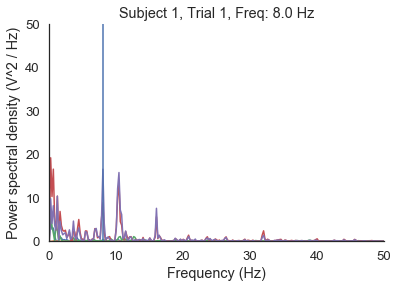

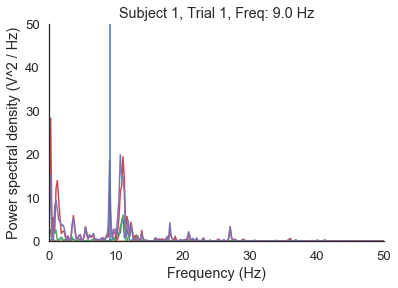

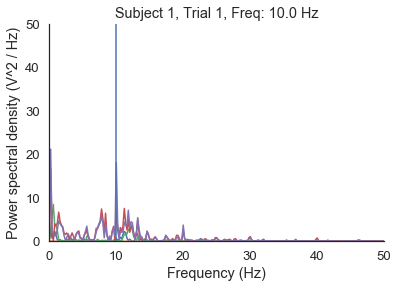

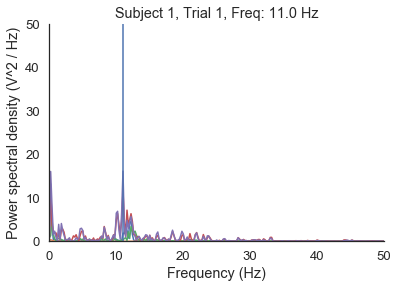

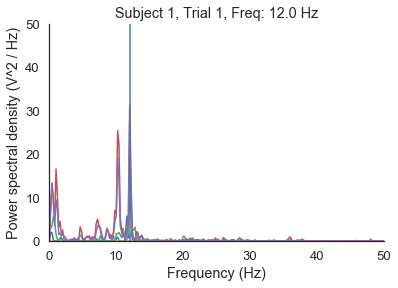

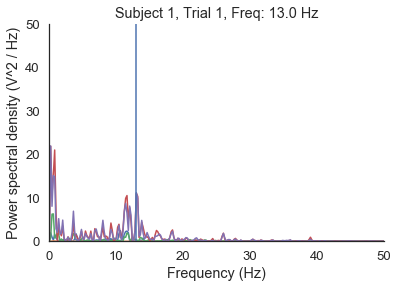

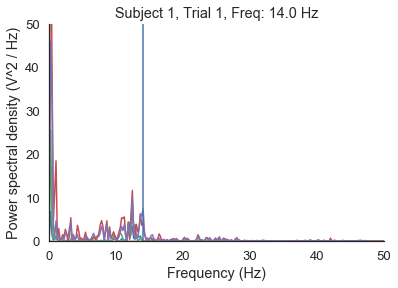

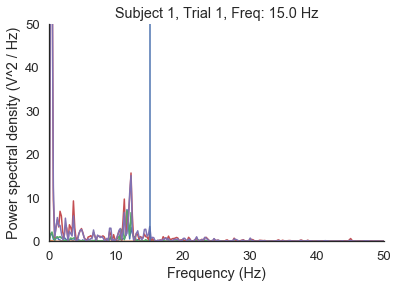

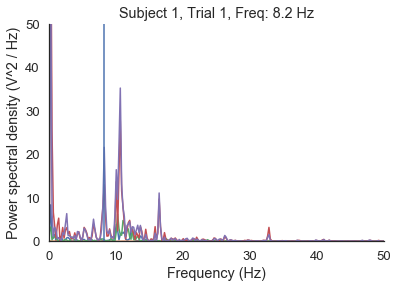

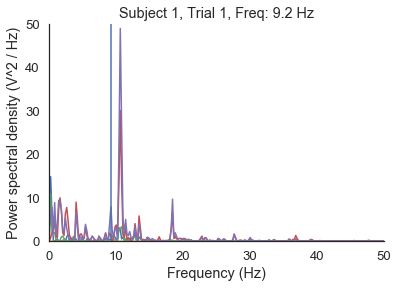

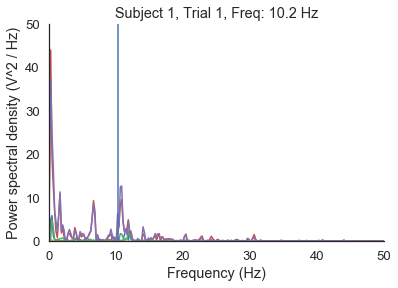

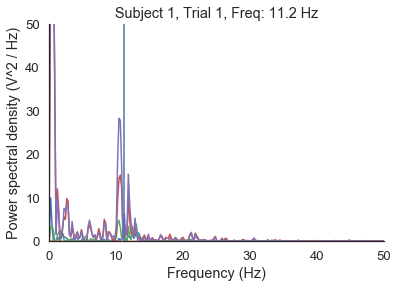

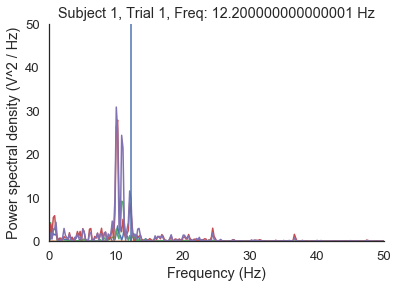

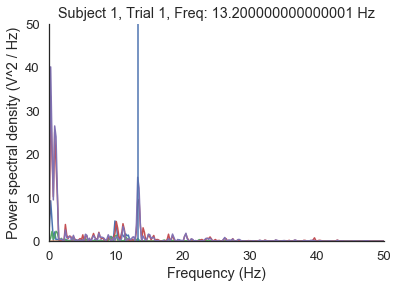

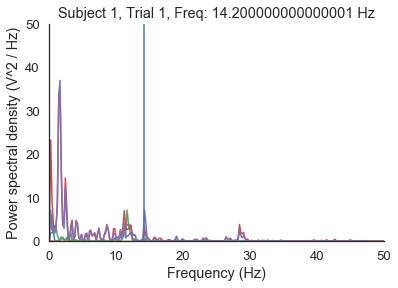

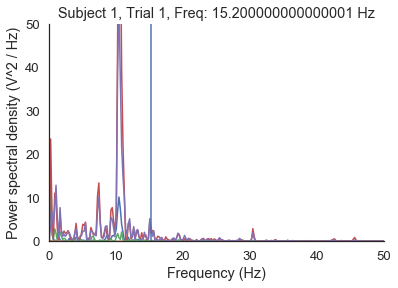

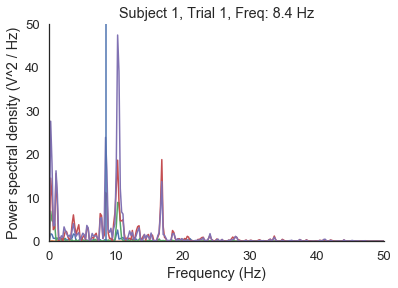

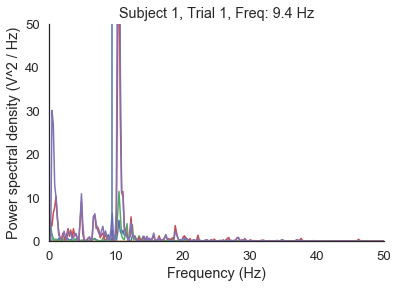

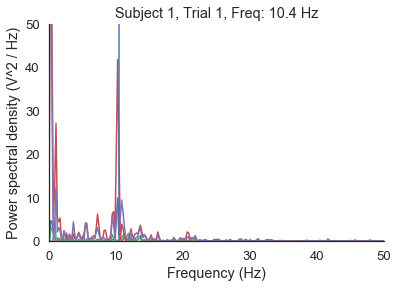

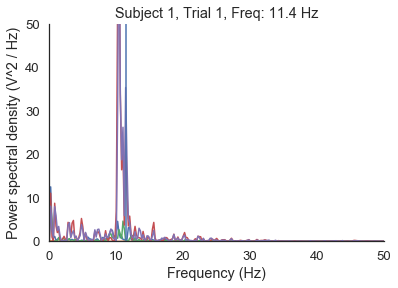

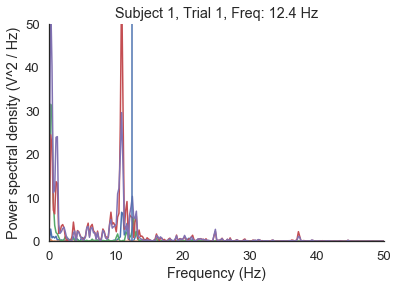

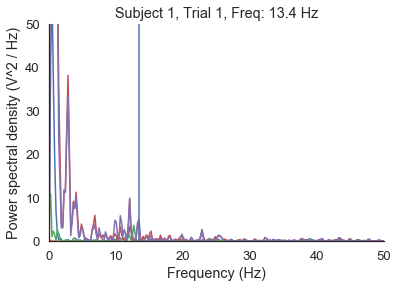

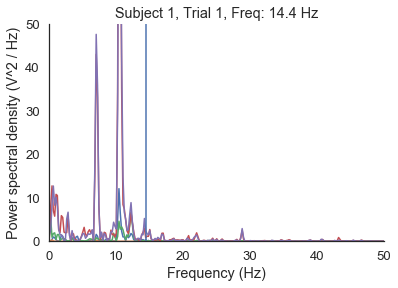

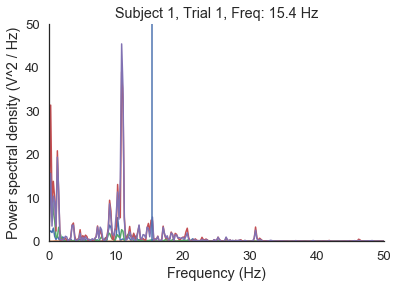

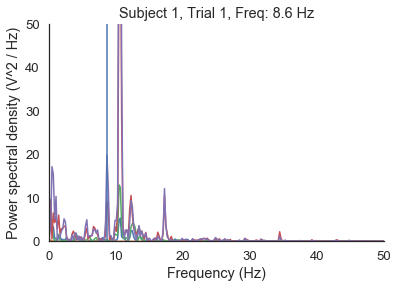

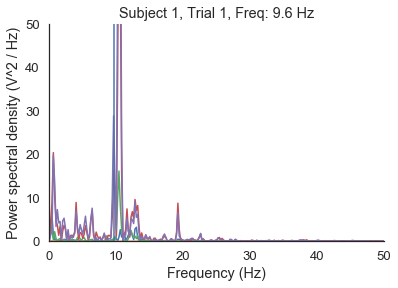

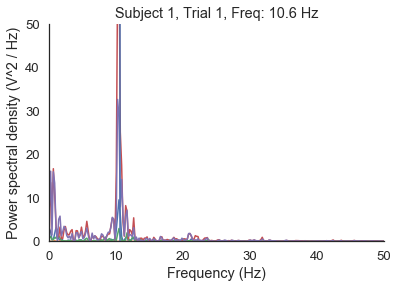

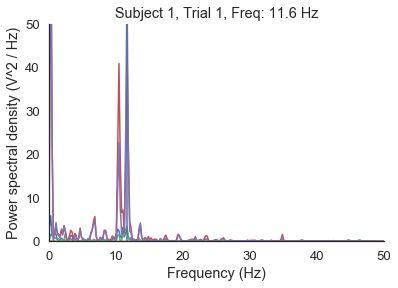

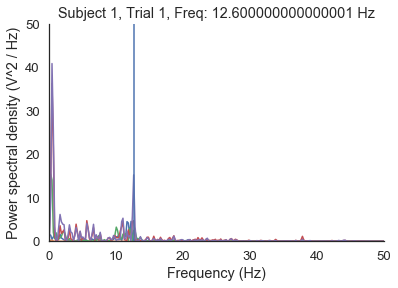

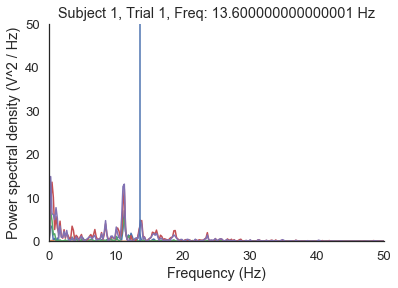

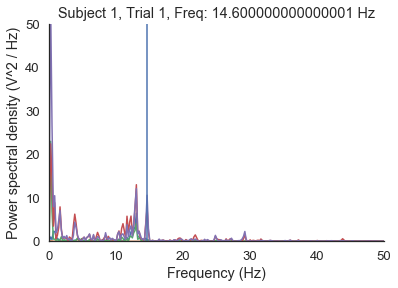

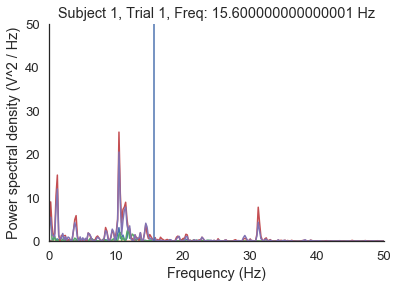

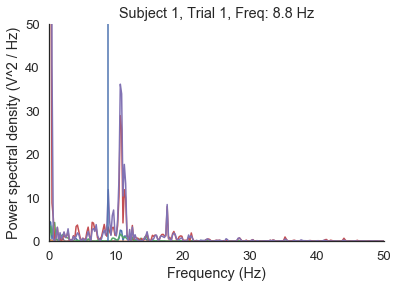

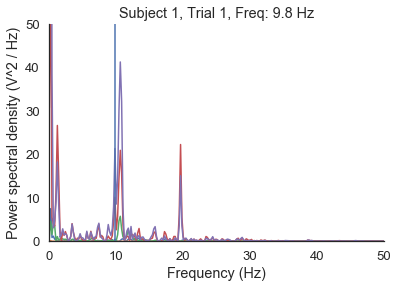

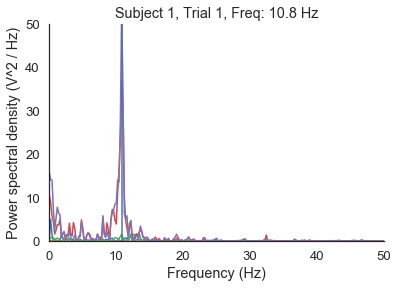

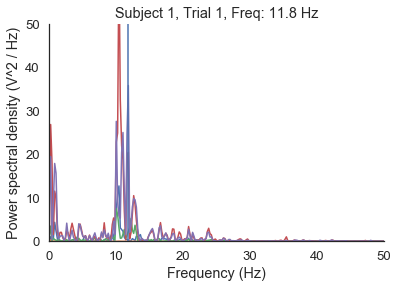

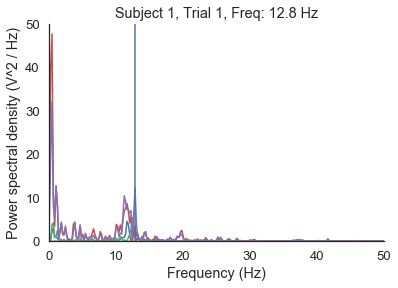

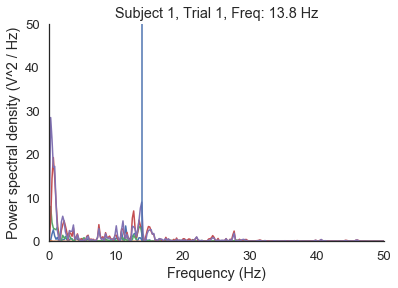

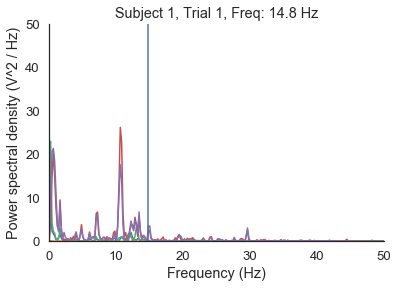

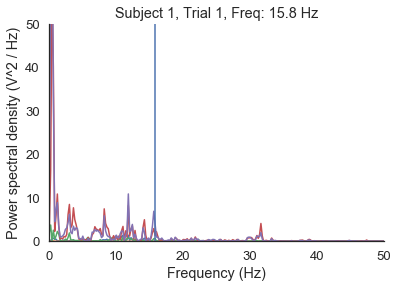

In [6]:
'Load Data'
mat = loadmat('BetaDataset/S1.mat')
freq_phase = loadmat('BetaDataset/Freq_Phase.mat')
data = mat['data']
labels = freq_phase['freqs']

'Vars'
dictionary = {'C3':26,'Cz':28,'C4':30,'O1':61,'O2':63}
five_ch = [25,27,29,60,62]
trial=0
epochs=40
freq_max = 50 # We are looking for something between 8-16 HZ

'Graph 5 channels'
for j in range (epochs):
    for i in range(5):
        sample = data[five_ch[i],125:1375,j,trial].T # Cut off the first and last 125 samples
        freqs, psd = signal.welch(sample, fs=sf, nperseg=win)
        sns.set(font_scale=1.2, style='white')
        plt.plot(freqs,psd)   
    sns.despine()
    plt.title("Subject 1, Trial 1, Freq: "+str(freq[0,j])+str(" Hz"))
    plt.ylabel('Power spectral density (V^2 / Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylim([0, 50])
    plt.xlim([0, freq_max])
    plt.axvline(x=freq[0,j])
    plt.axvline(x=freq[0,j]*2)
    plt.show()

<br>Cool. It looks like these channels are responsible for the high, predictive spike. We can go back to this some other time. But this should be good for now

#### Median PSD of all epochs by their target frequency

In [18]:
#Code here

## 2. Cross Subject Analysis

We have already inspected the dataset by epoching it and plotting the PSDs. Now we have to begin to evaluate the context. This should help us figure out what parameters we will use for our pipeline. I will be using the MOABB pipelines based on this tutorial: http://moabb.neurotechx.com/docs/auto_examples/plot_cross_subject_ssvep.html#sphx-glr-auto-examples-plot-cross-subject-ssvep-py/
<u>TL;DR</u>: There is too much cross subject variance. Different pipelines may fair better or worse with this variance. We will compare two pipelines: <b>RG + LogReg</b> and <b>CCA</b>. We will compute the <b>AUC</b> to score both pipelines. This analysis will help us understand which pipeline is more generalizable and robust for creating a functional BCI. Here's a list of all the MOABB pipelines: 

1. <b>RG + LogReg</b>: Logistic Regression.<br>
2. <b>CCA</b>: Canononical Correlation Analysis.<br>
3. <b>AUC</b>: Area Under ROC Curve. Ranging from 0 to 1, it is the probability that the model ranks a random positive example more highly than a random negative example. Learn more: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import Covariances

from moabb.evaluations import CrossSubjectEvaluation
from moabb.paradigms import SSVEP, FilterBankSSVEP
from moabb.datasets import SSVEPExo
from moabb.pipelines import SSVEP_CCA, ExtendedSSVEPSignal
import moabb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

ModuleNotFoundError: No module named 'moabb'

## 3. Build and Train Convolutional Neural Network (W.I.P.)

This masters thesis uses Magnitude Spectrum Features and Convolutional Neural Networks (M-CNN) and Complex Spectrum Features and Convolutional Neural Networks (C-CNN) for classification: https://uwspace.uwaterloo.ca/handle/10012/14881

In [55]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

print(tf.__version__)
print(keras.__version__)

2.3.1
2.4.0


#### Load and reshape data

In [89]:
'''Load Data'''
mat = loadmat('BetaDataset/S1.mat')
freq_phase = loadmat('BetaDataset/Freq_Phase.mat')
data = mat['data']
labels = freq_phase['freqs']
'''Reshape Data'''
five_ch = [25,27,29,60,62] # Channels we are interested in
data = data[five_ch,125:1375,:,:] # Splice array for desired channels and desired time
data = np.swapaxes(data,-1,-2) # Swap last two axes
data = data.reshape(5,1250,240) # Put all the epochs on one axis
data = np.swapaxes(data,-1,0)
labels = labels.reshape(40) # Get rid of redundant dimension
labels = np.tile(labels,6) # Multiply the labels by the amount of trials to match the 3rd axis of data
'''Print Shape'''
print(data.shape)
print(labels.shape)

# SANITY CHECK ALERT
'''
epoch = 209
sf = 250
win = 250*5
for i in range(5):
    sample = data[epoch,:,i].T # Cut off the first and last 125 samples
    freqs, psd = signal.welch(sample, fs=sf, nperseg=win)
    sns.set(font_scale=1.2, style='white')
    plt.plot(freqs,psd)   
sns.despine()
plt.title("Subject 1, Trial 1, Freq: "+str(labels[epoch])+str(" Hz"))
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylim([0, 50])
plt.xlim([0, 50])
plt.axvline(x=labels[epoch])
plt.show()
'''

(240, 1250, 5)
(240,)


'\nepoch = 209\nsf = 250\nwin = 250*5\nfor i in range(5):\n    sample = data[epoch,:,i].T # Cut off the first and last 125 samples\n    freqs, psd = signal.welch(sample, fs=sf, nperseg=win)\n    sns.set(font_scale=1.2, style=\'white\')\n    plt.plot(freqs,psd)   \nsns.despine()\nplt.title("Subject 1, Trial 1, Freq: "+str(labels[epoch])+str(" Hz"))\nplt.ylabel(\'Power spectral density (V^2 / Hz)\')\nplt.xlabel(\'Frequency (Hz)\')\nplt.ylim([0, 50])\nplt.xlim([0, 50])\nplt.axvline(x=labels[epoch])\nplt.show()\n'

>Try feeding the time series or the Fourier transformation to the CNN

#### Preprocessing

In [9]:
'''
# Turn data from the 64 channels into scalers
from sklearn.preprocessing import StandardScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])
'''

'\n# Turn data from the 64 channels into scalers\nfrom sklearn.preprocessing import StandardScaler\n\nscalers = {}\nfor i in range(X_train.shape[1]):\n    scalers[i] = StandardScaler()\n    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) \n\nfor i in range(X_test.shape[1]):\n    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])\n'

In [91]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train,X_test,y_train,y_test = train_test_split(data, labels, test_size = 0.3)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print('Training size, channels, convolution')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (168, 1250, 5)
y_train shape: (168,)
Training size, channels, convolution
X_test shape: (72, 1250, 5)
y_test shape: (72,)


#### 1D CNN Model

In [96]:
model = models.Sequential()
#64 is to preserve channels, 16 is kernel size
model.add(layers.Conv1D(5, 9, activation='relu', input_shape=X_train.shape[1:])) # Will give u same size
model.add(layers.MaxPooling1D(2)) # Will half the convolution. Take the larger of the two. Keep halfing until you get to 20, Until time series is small
model.add(layers.Conv1D(3, 9, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(2, 9, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(1, 9, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten()) # Flatten the data to put in 1D
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
# What dimension does the flatten layer "poop out"?
# Then add about 2 or 3 Dense layers that match this dimension
# Make the last layer "poop out" 1 value
model.summary()
#Compile
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 1242, 5)           230       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 621, 5)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 613, 3)            138       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 306, 3)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 298, 2)            56        
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 149, 2)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 141, 1)           

In [98]:
#Training
model.fit(X_train, y_train, epochs=40, batch_size=16, verbose=1)
#Testing
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Epoch 1/40
11/11 [==============================] - 0s 13ms/step - loss: 2.8243
Epoch 2/40
11/11 [==============================] - 0s 11ms/step - loss: 2.6348
Epoch 3/40
11/11 [==============================] - 0s 12ms/step - loss: 2.6295
Epoch 4/40
11/11 [==============================] - 0s 12ms/step - loss: 2.5168
Epoch 5/40
11/11 [==============================] - 0s 12ms/step - loss: 2.1763
Epoch 6/40
11/11 [==============================] - 0s 12ms/step - loss: 2.4112
Epoch 7/40
11/11 [==============================] - 0s 12ms/step - loss: 1.8784
Epoch 8/40
11/11 [==============================] - 0s 13ms/step - loss: 1.7369
Epoch 9/40
11/11 [==============================] - 0s 11ms/step - loss: 1.6538
Epoch 10/40
11/11 [==============================] - 0s 12ms/step - loss: 1.4827
Epoch 11/40
11/11 [==============================] - 0s 12ms/step - loss: 1.3839
Epoch 12/40
11/11 [==============================] - 0s 12ms/step - loss: 1.2612
Epoch 13/40
11/11 [==================

Yeee
>-That shit looked horrible
-Lmao